# Start

This script calculates slope, aspect, and relief of a selected square area in Australia from a DEM (Digital Elevation Model) `.tif` file.

📄 **What this script does**
1. Loads the Australia DEM `.tif` file, crops it using the intersection of the desired `bbox` and the Australia shapefile, and saves the result as `{location_name}_dem.tif` in the `output` folder.
2. Loads `{location_name}_dem.tif`, replaces negative values with 0 and `-9999` with `np.nan`, then saves the result as `{location_name}_dem_no_neg.tif` in the `output` folder.
3. Uses `gdal.DEMProcessing()` to generate `{location_name}_slope.tif` and `{location_name}_aspect.tif` from `{location_name}_dem_no_neg.tif`.
4. Calculates relief as the median elevation within 5 km tiles, and saves the result as `{location_name}_relief.tif` in the `output` folder.  
   Note: DEM values in offshore areas are filled with zeroes to enable relief calculation near coastlines.

⚠️ **Important notes**
* Before running the script, set all variables in the **first cell**, and delete the **second cell** if not using a Google Colab environment.  
  *(The script was developed for use in Google Colab and has not been tested outside of it.)*
* Some relief values near the `bbox` border may be inaccurately filled for convenience in coastal calculations. This should not affect results as long as selected points are not near the `bbox` border.


In [ ]:
working_dir = "/content/drive/My Drive/Work/2025.04 ANU Bushfire"
dem_tif_file_name = "dem_vic_nsw_act.tif"
data_exploration = False

australia_shp_folder_name = "STE_2021_AUST_SHP_GDA2020"

# Set interest areas data. Use large bbox to leave room for relief calculation
# Note: GDAL uses upper-left and lower-right corner
# TODO (LOW): Recalculate relief of coffs_harbour and port_macquaria areas.
#             The one calculated excluded border in which there are 0.0 in the square.
# location_name = "coffs_harbour"
# bbox = [152.7, -29.8, 153.4, -30.4]  # [minX, maxY, maxX, minY]

# location_name = "port_macquarie"
# bbox = [152.4, -31.2, 152.7, -31.7]

location_name = "batemans_bay"
# bbox = [150.0, -35.4, 150.3, -35.7]  # Small scope
bbox = [149.8, -35.2, 150.5, -36.3]  # Large scope

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calculation of slope and aspect with .tif DEM data

## Data loading and exploration

In [ ]:
# Get dem_tif_file_path

import os
import glob

if dem_tif_file_name == "":
    dem_tif_file_path = glob.glob(os.path.join(working_dir, "*.tif"))[0]
else:
    dem_tif_file_path = os.path.join(working_dir, dem_tif_file_name)

print(f"dem_tif_file_path: {dem_tif_file_path}")

dem_tif_file_path: /content/drive/My Drive/Work/2025.04 ANU Bushfire/dem_vic_nsw_act.tif


In [ ]:
!pip install rasterio

In [ ]:
# Read the metadata and the data

import rasterio
from rasterio.plot import show
import pprint

with rasterio.open(dem_tif_file_path) as src:
    print("Full metadata:")
    pprint.pp(src.profile)

    if data_exploration:
        data = src.read(1)  # Read the first band into a NumPy array
        print("\n")
        print(f"Data shape: {data.shape}")
        print(f"Data: {data}")

Full metadata:
{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 57955,
 'height': 40108,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["GDA94 / MGA zone 55",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28355"]]'),
 'transform': Affine(29.995641274315762, 0.0, -85045.91673131194,
       0.0, -29.995739875349898, 6868391.124632021),
 'blockxsize': 57955,
 'blockysize': 1,
 'tiled': False,
 'interleave': 'band'}


In [ ]:
# Exploring the data

import numpy as np

if data_exploration:
    print(f"Unique values: {np.unique(data[:10000, :10000])}")
    print(f"Data min: {data.min()}")
    print(f"Data max: {data.max()}")

## Pre-processing

In [ ]:
from shapely.geometry import box

def create_cutline_file(bbox, aus):
    bbox_poly = box(bbox[0], bbox[3], bbox[2], bbox[1])  # shapely box takes (minx, miny, maxx, maxy)
    intersection = aus.intersection(bbox_poly)
    intersection = gpd.GeoSeries(intersection).dropna().explode(index_parts=False)

    if intersection.is_empty.all():
        print("No intersection found.")
    else:
        # Save to file for use as cutline
        # TODO (LOW): Save cutline in a seperate folder
        cutline_gdf = gpd.GeoDataFrame(geometry=intersection, crs=aus.crs)
        cutline_gdf = cutline_gdf[~cutline_gdf.geometry.is_empty]
        cutline_path = os.path.join(output_dir, location_name + "_intersection_cutline.geojson")
        cutline_gdf.to_file(cutline_path, driver="GeoJSON")
        print(f"Cutline saved to: {cutline_path}")
        cutline_gdf.plot()
        return cutline_gdf, cutline_path

def create_cropped_dem_tif(output_tif, cutline_path):
    # Crop DEM using polygon cutline
    gdal.UseExceptions()
    try:
        gdal.Warp(
            output_tif,
            dem_tif_file_path,
            cutlineDSName=cutline_path,
            cropToCutline=True,
            dstNodata=-9999  # Or whatever is appropriate
        )
        print(f"Cropped DEM saved to: {output_tif}")
    except Exception as e:
        print("GDAL Warp error:", e)

Cutline saved to: /content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_intersection_cutline.geojson
Cropped DEM saved to: /content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_dem.tif


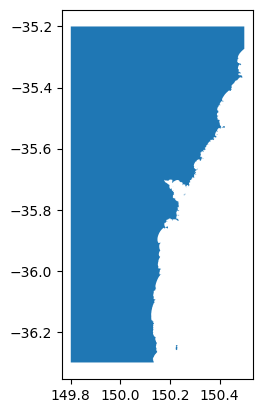

In [ ]:
# Get .tif of only interest areas (Start with the lCoffs Harbour area)

from osgeo import gdal
import geopandas as gpd

# Create a folder for storing .tif outputs
output_dir = os.path.join(working_dir, "output")
os.makedirs(output_dir, exist_ok=True)

# Read shapefile of Australia
australia_shp_folder_path = os.path.join(working_dir, australia_shp_folder_name)
australia_shp_file_path = glob.glob(os.path.join(australia_shp_folder_path, "*.shp"))[0]
aus = gpd.read_file(australia_shp_file_path)

# Get cropped .tif dem file
cutline_gdf, cutline_path = create_cutline_file(bbox, aus)
cropped_dem_tif_path = os.path.join(output_dir, location_name + "_dem.tif")
create_cropped_dem_tif(cropped_dem_tif_path, cutline_path)

In [ ]:
# Explore the cropped .tif dem file
import rasterio
from rasterio.plot import show
import pprint

with rasterio.open(cropped_dem_tif_path) as src:
    print("Full metadata:")
    profile = src.profile
    pprint.pp(profile)

    data = src.read(1)  # Read the first band into a NumPy array
    print("\n")
    print(f"Data shape: {data.shape}")
    print(f"Data: {data}")

    print(f"Unique values: {np.unique(data)}")
    print(f"Data min: {data.min()}")
    print(f"Data max: {data.max()}")

Full metadata:
{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 2241,
 'height': 4098,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["GDA94 / MGA zone 55",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28355"]]'),
 'transform': Affine(29.995641274315783, 0.0, 751442.5314855317,
       0.0, -29.995739875349962, 6101160.090100322),
 'blockxsize': 2241,
 'blockysize': 1,
 'tiled': False,
 'interleave': 'band'}


Data shape: (4098, 2241

No negative cropped DEM saved to: /content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_dem_no_neg.tif


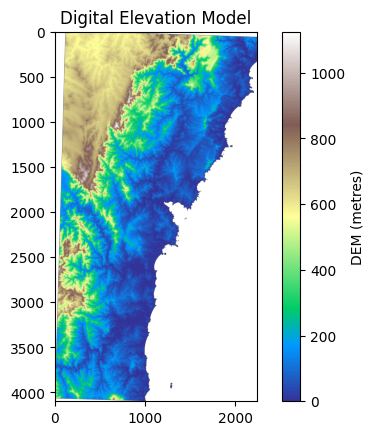

In [ ]:
# Remove negative values with zeroes

from matplotlib import pyplot as plt

data[data == -9999.0] = np.nan
data[data < 0.0] = 0.0

no_neg_cropped_dem_tif_path = os.path.join(output_dir, location_name + "_dem_no_neg.tif")
with rasterio.open(no_neg_cropped_dem_tif_path, 'w', **profile) as dst:
    dst.write(data, 1)
    print(f"No negative cropped DEM saved to: {no_neg_cropped_dem_tif_path}")

    plt.imshow(data, cmap='terrain')
    plt.colorbar(label='DEM (metres)')
    plt.title('Digital Elevation Model')
    plt.show()

## Calculation

### Slope

Slope saved to: /content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_slope.tif
Slope calculation complete.


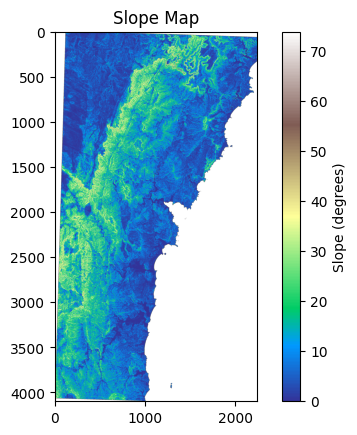

In [ ]:
# Computing and visualise slope from . tif DEM data

from osgeo import gdal
import matplotlib.pyplot as plt
import rasterio

slope_path = os.path.join(output_dir, location_name + "_slope.tif")
print(f"Slope saved to: {slope_path}")

# Compute slope
gdal.DEMProcessing(
    slope_path,                  # Output file path
    no_neg_cropped_dem_tif_path,   # Input DEM file
    'slope',                       # Processing type
    format='GTiff',                # Output format
    computeEdges=True,             # Avoid edge artifacts
    slopeFormat='degree'           # Options: 'degree' or 'percent'
)

print("Slope calculation complete.")

# Visualise output slope with matplotlib
with rasterio.open(slope_path) as src:
    slope_data = src.read(1)

plt.imshow(slope_data, cmap='terrain')
plt.colorbar(label='Slope (degrees)')
plt.title('Slope Map')
plt.show()

### Aspect

Aspect saved to: /content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_aspect.tif
Aspect calculation complete.


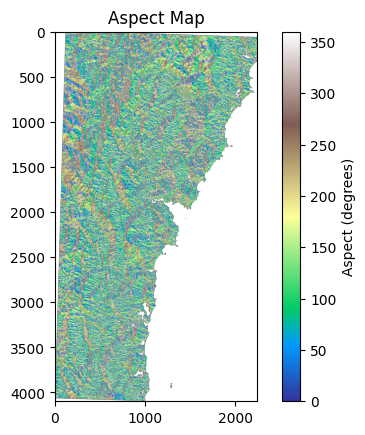

In [ ]:
# Computing and visualise aspect from . tif DEM data

aspect_path = os.path.join(output_dir, location_name + "_aspect.tif")
print(f"Aspect saved to: {aspect_path}")

# Compute aspect
gdal.DEMProcessing(
    aspect_path,                   # Output file path
    no_neg_cropped_dem_tif_path,   # Input DEM file
    'aspect',                      # Processing type
    format='GTiff',                # Output format
    computeEdges=True              # Avoid edge artifacts
)

print("Aspect calculation complete.")

# Visualise output aspect with matplotlib
with rasterio.open(aspect_path) as src:
    aspect_data = src.read(1)

aspect_data[aspect_data == -9999] = np.nan
plt.imshow(aspect_data, cmap='terrain')
plt.colorbar(label='Aspect (degrees)')
plt.title('Aspect Map')
plt.show()

### Relief
Some supposedly np.nan relief values around the boarder are filled in inaccurately for the sake of convenient sea area calulation. This will not be a problem as long as points used are not near the boarder.

In [ ]:
# Compute relief (aka Topographic position index) with median of all tiles in 5 km square

import os
import math
import numpy as np
import rasterio

def calculate_relief_for_tile(dem_data, x, y):
    reach = math.floor(2500 / 30)
    square = dem_data[y - reach:y + reach, x - reach:x + reach]
    # if 0.0 in square:
    #     print(f"Skip calculation at ({x}, {y}) because the square contains 0.0")
    #     return np.nan
    median_dem = np.median(square)  # return NaN if any NaN is present in the array
    relief = dem_data[y, x] - median_dem
    print(f"Relief at ({x}, {y}): {relief}")
    return relief

# Compute relief for the whole area
with rasterio.open(no_neg_cropped_dem_tif_path) as src:
    dem_data = src.read(1)

# Fill in dem for the sea area as zeroes
# TODO (LOW): Make the border remain np.nan for accurate representation.
#   The mask is fill with only 255 when the boarder supposed to be 0.
dem_data = np.nan_to_num(dem_data, nan=0.0)

relief_data = np.zeros(dem_data.shape)
relief_data.fill(np.nan)
# TODO (LOW): Choose better padding
padding = math.floor(2500 / 30)
for y in range(padding, dem_data.shape[0] - padding):
    for x in range(padding, dem_data.shape[1] - padding):
        relief_data[y, x] = calculate_relief_for_tile(dem_data, x, y)

Streaming output truncated to the last 5000 lines.
Relief at (1308, 4012): 0.0
Relief at (1309, 4012): 0.0
Relief at (1310, 4012): 0.0
Relief at (1311, 4012): 0.0
Relief at (1312, 4012): 0.0
Relief at (1313, 4012): 0.0
Relief at (1314, 4012): 0.0
Relief at (1315, 4012): 0.0
Relief at (1316, 4012): 0.0
Relief at (1317, 4012): 0.0
Relief at (1318, 4012): 0.0
Relief at (1319, 4012): 0.0
Relief at (1320, 4012): 0.0
Relief at (1321, 4012): 0.0
Relief at (1322, 4012): 0.0
Relief at (1323, 4012): 0.0
Relief at (1324, 4012): 0.0
Relief at (1325, 4012): 0.0
Relief at (1326, 4012): 0.0
Relief at (1327, 4012): 0.0
Relief at (1328, 4012): 0.0
Relief at (1329, 4012): 0.0
Relief at (1330, 4012): 0.0
Relief at (1331, 4012): 0.0
Relief at (1332, 4012): 0.0
Relief at (1333, 4012): 0.0
Relief at (1334, 4012): 0.0
Relief at (1335, 4012): 0.0
Relief at (1336, 4012): 0.0
Relief at (1337, 4012): 0.0
Relief at (1338, 4012): 0.0
Relief at (1339, 4012): 0.0
Relief at (1340, 4012): 0.0
Relief at (1341, 4012): 0

Relief saved to: /content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_relief.tif


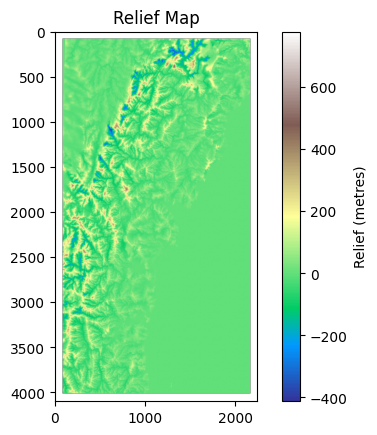

In [ ]:
# Visualise relief calculated

relief_path = os.path.join(output_dir, location_name + "_relief.tif")
with rasterio.open(relief_path, 'w', **profile) as dst:
    dst.write(relief_data, 1)
    print(f"Relief saved to: {relief_path}")

plt.imshow(relief_data, cmap='terrain')
plt.colorbar(label='Relief (metres)')
plt.title('Relief Map')
plt.show()

In [ ]:
# Notify when finish running
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
stop

# (Fail) Calculation of slope and aspect with .gdb DEM data


In [ ]:
working_dir = "/content/drive/My Drive/Work/2025.04 ANU Bushfire"
dem_data_url = "https://datasets.seed.nsw.gov.au/dataset/b708a743-ea84-433a-a8e9-10b1d2829e6a/resource/ad8129d2-4ff5-4889-9b39-11240530dcb5/download/climatedem.zip"

In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# prompt: download a zip file
# NOTE: Took 6 minutes

import requests
from io import BytesIO
from zipfile import ZipFile

def download_unzip(url, extract_to='.'):
  response = requests.get(url)
  response.raise_for_status()

  with ZipFile(BytesIO(response.content)) as zfile:
    zfile.extractall(extract_to)

# TODO: Skip download if file exists
download_unzip(dem_data_url, working_dir)

In [ ]:
# Get gbd_file_path

import os
import glob

gdb_file_path = glob.glob(os.path.join(working_dir, "*/*.gdb"))[0]
print(f"gdb_file_path: {gdb_file_path}")

In [ ]:
# Use OpenFileGDB driver to get available layers in the .gdb file

from osgeo import ogr

driver = ogr.GetDriverByName("OpenFileGDB")
data_source = driver.Open(gdb_file_path, 0)  # 0 = read-only

if data_source is None:
    print("Failed to open GDB.")
else:
    print("Layers found:")
    for i in range(data_source.GetLayerCount()):
        layer_name = data_source.GetLayer(i).GetName()
        print("-", layer_name)
        layer = data_source.GetLayerByName(layer_name)

        print("    Feature count:", layer.GetFeatureCount())
        print("    Geometry type:", layer.GetGeomType())

        print("    First feature fields:")
        feature = layer.GetNextFeature()
        for i in range(feature.GetFieldCount()):
            print(f"      {feature.GetFieldDefnRef(i).GetName()}: {feature.GetField(i)}")

In [ ]:
# (Not interpretable) View DEM block_data

import zlib
import numpy as np

layer_name = "fras_blk_lf_dem1sec_noExclusions_noNegValues"
layer = data_source.GetLayerByName(layer_name)
feature = layer.GetNextFeature()

i = 4
block_data = feature.GetField(i)
print(f"{feature.GetFieldDefnRef(i).GetName()}: {feature.GetField(i)}")

# Decompress the hexadecimal data
raw = bytes.fromhex(block_data)
decompressed = zlib.decompress(raw)
print(f"decompress (first 100 elements): {decompressed[:100]}")

# Applied np conversion
arr = np.frombuffer(decompressed, dtype=np.int16)
print(f"Numpy converted (first 100 elements): {arr[:100]}")

In [ ]:
# (Fail) Converting .gdb to .tif

from osgeo import gdal

layer_name = "fras_blk_lf_dem1sec_noExclusions_noNegValues"
input_path = f"{gdb_file_path}/{layer_name}"
output_tif = os.path.join(working_dir, "dem.tif")

# Open and export
gdal.Translate(output_tif, input_path, format="GTiff")
print("Export complete:", output_tif)

# Notes


## Upload a zipped folder with Colab

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
%cd "{working_dir}"
!ls -al

In [ ]:
import zipfile

with zipfile.ZipFile(os.path.join(working_dir, "STE_2021_AUST_SHP_GDA2020.zip"), 'r') as zip_ref:
    zip_ref.extractall(working_dir)